In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import os
from pathlib import Path
import warnings
from IPython.display import clear_output

# Get the parent directory and add it to sys.path
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

warnings.filterwarnings("ignore")

from data_builder import TimeSeriesBuilder, read_trans, read_labels
from utils import read_data, set_seed
from models import Model
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from training import train, test
from tqdm import tqdm

### 1. Build time-series samples for each gene

In [10]:
# load transcripts and cell types
folder = '../../Xenium/BreastS1R1/'
save_path = folder + 'TimeSeries/'
cell_types = read_labels(filename=folder + 'Cell_Barcode_Type_Matrices.xlsx', sheet='Xenium R1 Fig1-5 (supervised)')
gene_list = sorted([f[:-4] for f in os.listdir(folder+'MoleculesPerGene') if f.endswith('.csv')])
for i in range(183, len(gene_list)):
    gene = gene_list[i]
    clear_output(wait=True)
    print(f'Processing the {i+1}-th gene: {gene}')
    transcripts = read_trans(folder + 'MoleculesPerGene/' + gene + '.csv')
    num_cells = transcripts['cell_id'].nunique()
    # Build time series
    tsb = TimeSeriesBuilder(transcripts, cell_types)
    tsb.run(num_samples=int(num_cells/5), save_path=save_path, gene=gene)

Processing the 313-th gene: ZNF562
Building cell dictionaries
Find spatial neighbors
Build cell feature vectors
Calculate random walk transition probabilities
Start building the dataset


100%|██████████| 13305/13305 [00:01<00:00, 7609.29it/s]


13305 time-series samples of ZNF562 generated


### 2. Training for each gene

In [11]:
# Set parameters
SEQ_LEN = 20
dim_inputs = 10
hidden_size = 100
latent_size = 100

batch_size = 1024
base_lr = 0.01
lr_step = 10
num_epochs = 100

In [50]:
data_folder = folder + 'TimeSeries/'
model_folder = folder + 'Models/'

# Fetch the list of genes
gene_list = [f.split('_')[0] for f in os.listdir(data_folder) if f.endswith('.csv')]
# Remove duplicates
gene_list = sorted(list(set(gene_list)))

for i in range(len(gene_list)):
    gene = gene_list[i]
    clear_output(wait=True)
    print(f'Training gene: {gene}')
    # data loading and training
    data_path = data_folder + gene + '_data.csv'
    locs_path = data_folder + gene + '_locs.csv'
    data, locs = read_data(data_path, locs_path, SEQ_LEN, dim_inputs)
    training_size = int(data.shape[0] * 0.8)  # 80% of the data is used for training
    train_data = data[:training_size]
    train_locs = locs[:training_size]
    set_seed(42)
    net, _, _ = train(train_data, train_locs, batch_size, base_lr, lr_step, num_epochs, hidden_size, latent_size, SEQ_LEN)
    # save the trained model
    torch.save(net.state_dict(), model_folder + gene + '_model.pth')

Training gene: ZNF562
(13304, 20, 10)


Training: 100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


### 3. Test and evaluation

In [69]:
folder = '../../Xenium/BreastS1R1/'
data_folder = folder + 'TimeSeries/'
model_folder = folder + 'Models/'
# Fetch the list of genes
gene_list = [f.split('_')[0] for f in os.listdir(data_folder) if f.endswith('.csv')]
# Remove duplicates
gene_list = sorted(list(set(gene_list)))

# Set parameters
SEQ_LEN = 20
dim_inputs = 10
hidden_size = 100
latent_size = 100

mse_per_gene = {}

for gene in tqdm(gene_list, desc='Testing'):
    # load test data
    data_path = data_folder + gene + '_data.csv'
    locs_path = data_folder + gene + '_locs.csv'
    data, locs = read_data(data_path, locs_path, SEQ_LEN, dim_inputs)
    test_size = int(data.shape[0] * 0.1)
    test_data = data[-test_size:]
    test_locs = locs[-test_size:]
    # load the trained model and start test
    model_path = model_folder + gene + '_model.pth'
    net = Model(dim_inputs, hidden_size, latent_size, SEQ_LEN)
    net.load_state_dict(torch.load(model_path))
    prediction, generation, trans_status, loss_recon = test(test_data, test_locs, net)
    mse_per_gene[gene] = loss_recon.item()

Testing: 100%|██████████| 222/222 [00:59<00:00,  3.72it/s]


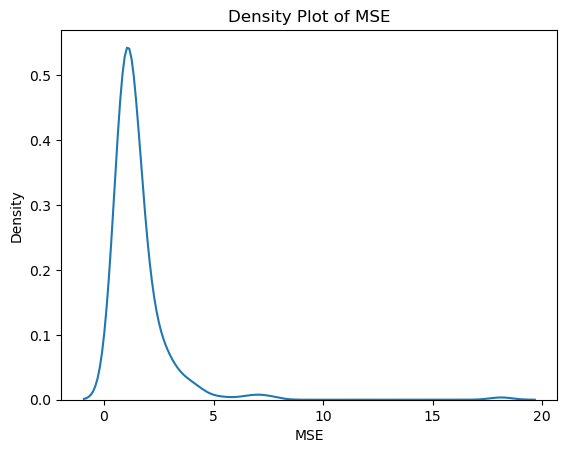

In [72]:
import seaborn as sns
# Get the MSE values
mse_values = list(mse_per_gene.values())

# Plot the density plot
sns.kdeplot(mse_values)
plt.xlabel('MSE')
plt.ylabel('Density')
plt.title('Density Plot of MSE')
plt.show()

### 4. Use some genes to show the MSE loss during training

In [13]:
folder = '../../Xenium/BreastS1R1/'
data_folder = folder + 'TimeSeries/'
model_folder = folder + 'Models/'

# Set parameters
SEQ_LEN = 20
dim_inputs = 10
hidden_size = 100
latent_size = 100

batch_size = 1024
base_lr = 0.01
lr_step = 10
num_epochs = 100

gene = 'GATA3'
# data loading and training
data_path = data_folder + gene + '_data.csv'
locs_path = data_folder + gene + '_locs.csv'
data, locs = read_data(data_path, locs_path, SEQ_LEN, dim_inputs)
training_size = int(data.shape[0] * 0.8)  # 80% of the data is used for training
val_size = int(training_size * 0.1)  # 10% of the data is used for validation
train_data = data[:training_size]
train_locs = locs[:training_size]
val_data = data[training_size:training_size + val_size]
val_locs = locs[training_size:training_size + val_size]
set_seed(42)
net, mse_train, mse_val = train(train_data, train_locs, batch_size, base_lr, lr_step, num_epochs, hidden_size, latent_size, SEQ_LEN, val_data, val_locs)
torch.save(net.state_dict(), model_folder + gene + '_model.pth')

Training: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s]


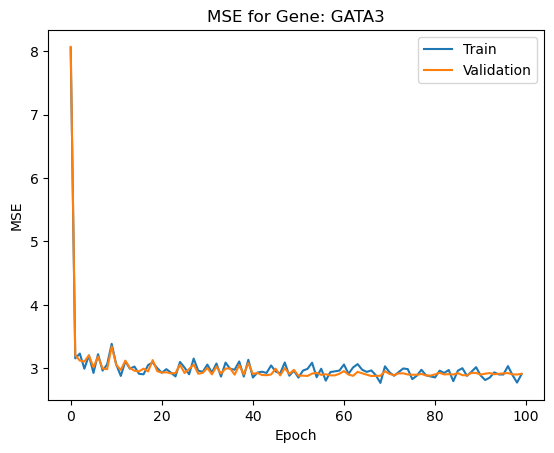

In [7]:
import matplotlib.pyplot as plt

# Plot the curves
plt.plot(mse_train, label='Train')
plt.plot(mse_val, label='Validation')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE for Gene: ' + gene)
plt.legend()

# Show the plot
plt.show()

### 5. Visualize test time-series cells and predictions

In [8]:
folder = '../../Xenium/BreastS1R1/'
data_folder = folder + 'TimeSeries/'
model_folder = folder + 'Models/'

# Set parameters
SEQ_LEN = 20
dim_inputs = 10
hidden_size = 100
latent_size = 100

gene = 'GATA3'
# load test data
data_path = data_folder + gene + '_data.csv'
locs_path = data_folder + gene + '_locs.csv'
data, locs = read_data(data_path, locs_path, SEQ_LEN, dim_inputs)
test_size = int(data.shape[0] * 0.1)
test_data = data[-test_size:]
test_locs = locs[-test_size:]
# load the trained model and start test
model_path = model_folder + gene + '_model.pth'
net = Model(dim_inputs, hidden_size, latent_size, SEQ_LEN)
net.load_state_dict(torch.load(model_path))
prediction, generation, trans_status, loss_recon = test(test_data, test_locs, net)
prediction = prediction.cpu().detach().numpy()

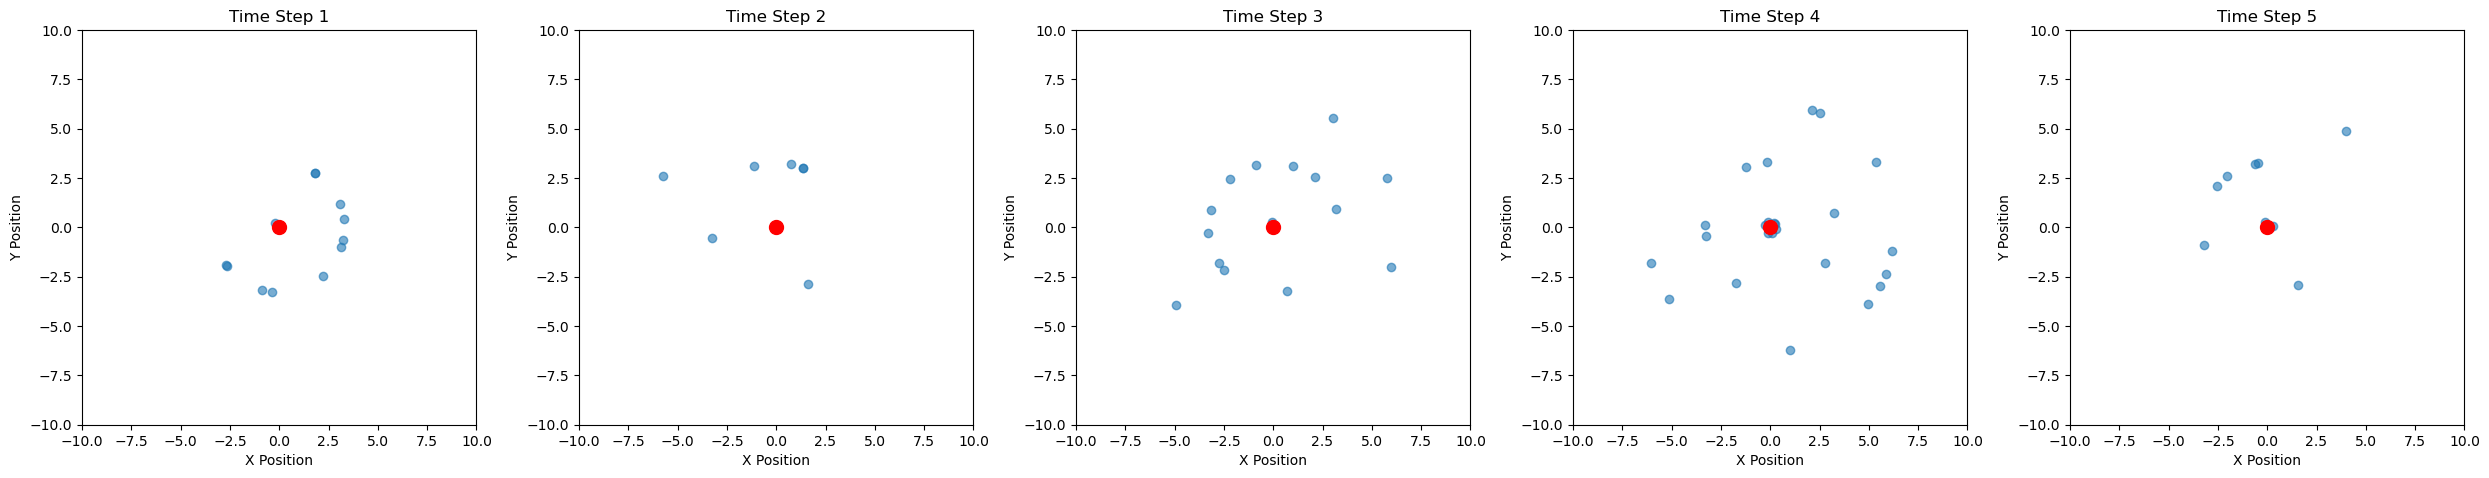

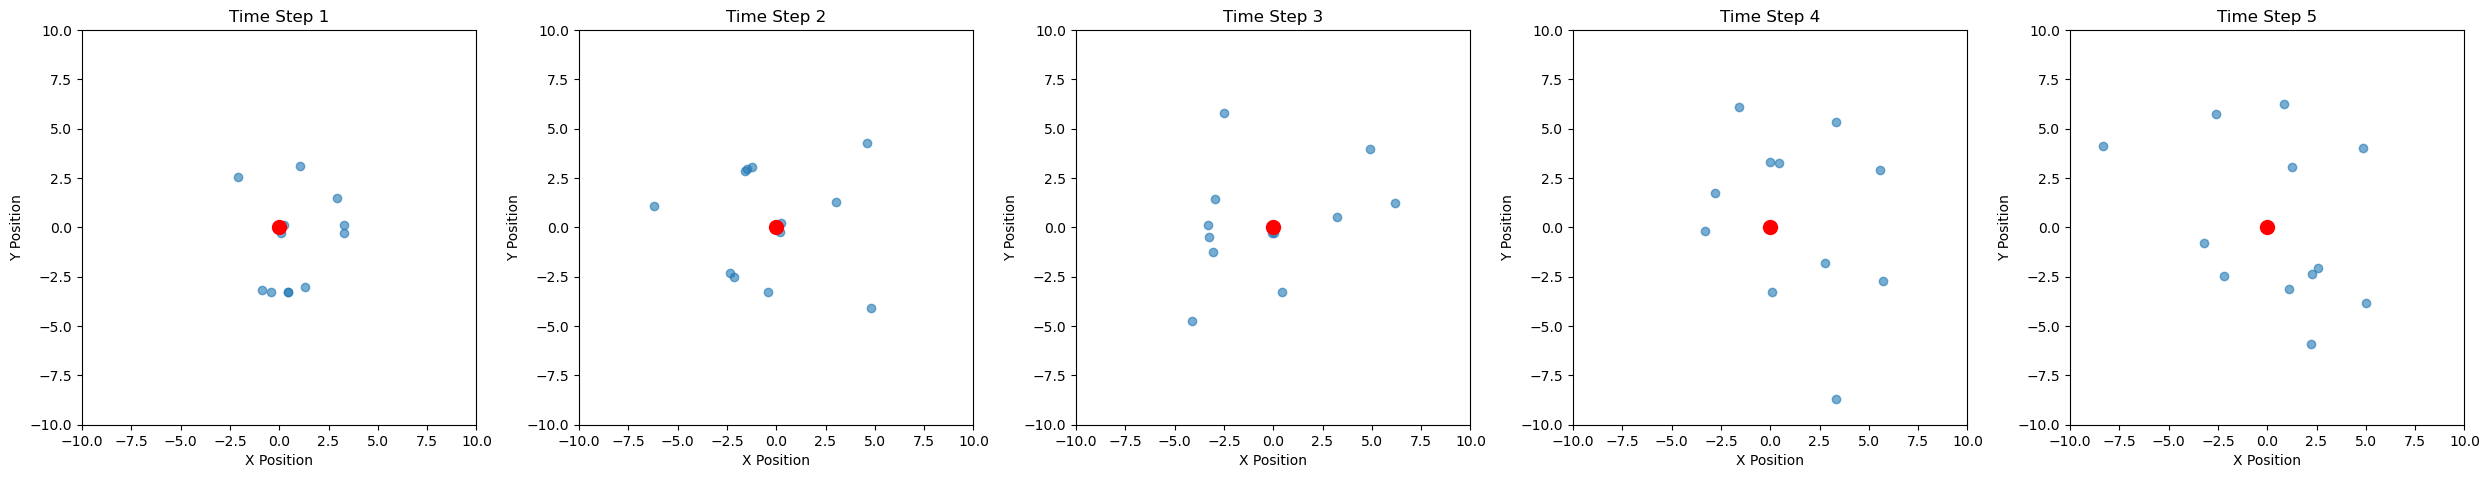

In [9]:
from utils import visulize_cell

visulize_cell(test_data[80][:5])
visulize_cell(prediction[80][:5])

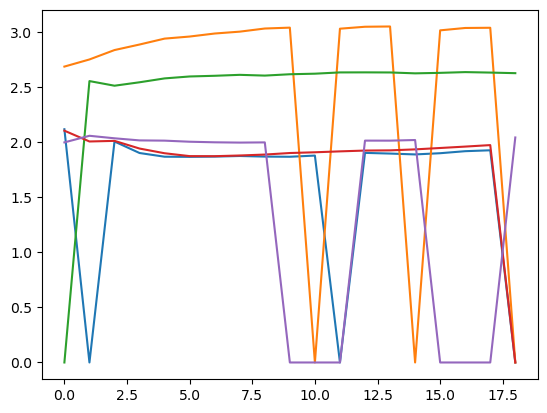

: 

In [14]:
folder = '../../Xenium/BreastS1R1/'
data_folder = folder + 'TimeSeries/'
model_folder = folder + 'Models/'

# Set parameters
SEQ_LEN = 20
dim_inputs = 10
hidden_size = 100
latent_size = 100

gene = 'GATA3'
# load test data
data_path = data_folder + gene + '_data.csv'
locs_path = data_folder + gene + '_locs.csv'
data, locs = read_data(data_path, locs_path, SEQ_LEN, dim_inputs)
test_size = int(data.shape[0] * 0.1)
test_data = data[-test_size:]
test_locs = locs[-test_size:]

prediction, generation, trans_status, loss_recon = test(test_data, test_locs, net)
prediction = prediction.cpu().detach().numpy()

for i in range(5,10):
    gen = generation[i].view(-1).cpu().detach().numpy()
    status = trans_status[i].view(-1).cpu().detach().numpy()
    plt.plot(status*gen)
plt.show()